## NN Adv Assignment

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

In [27]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

Device: cpu


### Load Data

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [3]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [4]:
train['label'].nunique()

10

In [5]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,67,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,2,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,93,58,78,45,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,71,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,63,0,0,0,0,0,0,0


In [21]:
X = train.iloc[:, :-1]#.values
y = train.iloc[:, -1]#.values

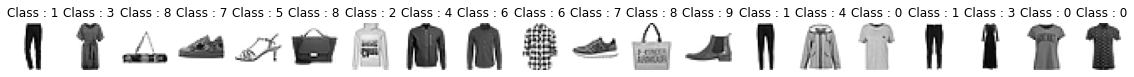

In [7]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [8]:
X_test = test.values

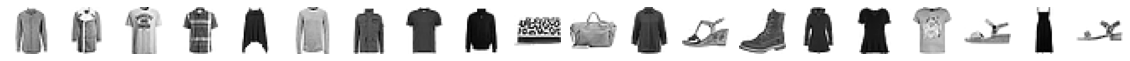

In [9]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

# 정규화를 해준다.
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [13]:
from torch.utils.data import DataLoader

In [23]:
pd.DataFrame(pd.concat([X_train,y_train],axis=1)).to_csv("train.csv", index =False)
pd.DataFrame(pd.concat([X_val,y_val],axis=1)).to_csv("val.csv", index = False)

In [24]:
class Dataset(Dataset):
    def __init__(self, csv, transform=None):
        self.csv = pd.read_csv(csv)
        self.image_ids = self.csv.index
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        image = self.csv.iloc[index,:-1]   
        label = self.csv.iloc[index,-1]         
        return (torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long))

In [25]:
trainset = Dataset("train.csv")
valset = Dataset("val.csv")

In [35]:
train_loader = DataLoader(trainset,batch_size = 128, shuffle= True)
val_loader = DataLoader(valset,batch_size = 128, shuffle= True) # validation

In [28]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

In [29]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [30]:
def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

In [31]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    d = 0.5
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 784),
        nn.BatchNorm1d(784),
        nn.LeakyReLU(),
        nn.Dropout(d)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(784, 784),
        nn.BatchNorm1d(784),
        nn.LeakyReLU(),
        nn.Dropout(d)
    )

    self.linear3 = nn.Sequential(
        nn.Linear(784, 512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(),
        nn.Dropout(d)
    )

    self.linear4 = nn.Sequential(
        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(),
        nn.Dropout(d)
    )



    self.linear5 = nn.Sequential(
        nn.Linear(512, 10)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
    for m in self.linear4:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)  
    for m in self.linear5:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    x = self.linear5(x)


    return x

In [32]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
  )
  (linear2): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
  )
  (linear3): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
  )
  (linear4): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01

In [36]:
EPOCHS = 50
result_list = []
for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader)
    val_loss, val_accuracy = evaluate(model, val_loader)
    print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
    result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

    result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.5034, 	Train Accuracy: 81.97 %, 	Val Loss: 0.3815, 	Val Accuracy: 85.72 % 

[EPOCH: 2], 	Train Loss: 0.4510, 	Train Accuracy: 83.94 %, 	Val Loss: 0.3562, 	Val Accuracy: 86.87 % 

[EPOCH: 3], 	Train Loss: 0.4179, 	Train Accuracy: 84.95 %, 	Val Loss: 0.3375, 	Val Accuracy: 87.59 % 

[EPOCH: 4], 	Train Loss: 0.4001, 	Train Accuracy: 85.52 %, 	Val Loss: 0.3307, 	Val Accuracy: 87.82 % 

[EPOCH: 5], 	Train Loss: 0.3821, 	Train Accuracy: 86.16 %, 	Val Loss: 0.3206, 	Val Accuracy: 88.20 % 

[EPOCH: 6], 	Train Loss: 0.3700, 	Train Accuracy: 86.60 %, 	Val Loss: 0.3186, 	Val Accuracy: 88.34 % 

[EPOCH: 7], 	Train Loss: 0.3598, 	Train Accuracy: 87.01 %, 	Val Loss: 0.3147, 	Val Accuracy: 88.29 % 

[EPOCH: 8], 	Train Loss: 0.3460, 	Train Accuracy: 87.29 %, 	Val Loss: 0.3147, 	Val Accuracy: 88.19 % 

[EPOCH: 9], 	Train Loss: 0.3343, 	Train Accuracy: 87.76 %, 	Val Loss: 0.3136, 	Val Accuracy: 88.42 % 

[EPOCH: 10], 	Train Loss: 0.3304, 	Train Accuracy: 87.99 %, 	Val Loss: 0.

KeyboardInterrupt: ignored